In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [4]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import ContactAveraging
from june.infection import Infection
from june.infection.symptoms import SymptomsConstant
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.seed import Seed
from june.policy import SocialDistancing, CloseSchools, CloseCompanies, Policies, PermanentPolicy
from june import paths
from june.logger.read_logger import ReadLogger
from june.infection.infection import InfectionSelector
from june.world import generate_world_from_hdf5, generate_world_from_geography

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [5]:
%%time
geography = Geography.from_file({
                                "super_area": 
                                          ["E02001720",
                                          "E00088544", 
                                          "E02002560", 
                                          "E02002559"]
                                }
                                )

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True)


2020-06-13 10:53:43,390 - june.demography.geography - INFO - There are 76 areas and 3 super_areas in the world.
2020-06-13 10:53:43,396 - june.groups.hospital - INFO - There are 2 hospitals in this geography.
2020-06-13 10:53:43,459 - june.groups.school - INFO - There are 10 schools in this geography.
2020-06-13 10:53:43,477 - june.groups.school - INFO - No school for the age 0 in this world.
2020-06-13 10:53:43,479 - june.groups.school - INFO - No school for the age 1 in this world.
2020-06-13 10:53:43,483 - june.groups.school - INFO - No school for the age 2 in this world.
2020-06-13 10:53:43,759 - june.groups.carehome - INFO - There are 2 care_homes in this geography.
2020-06-13 10:53:49,115 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.
2020-06-13 10:53:51,127 - june.distributors.worker_distributor - INFO - There are 0 who had to be told to stay real
CPU times: user 10.6 s, sys: 658 ms, total: 11.2 s
Wall time: 11.3 s


### If it took a long time to run the previous command, it might be a good idea to save the world to reuse it later.

In [6]:
#world.to_hdf5("world.hdf5")

If we would like to load the world we saved, we just do

In [7]:
#world = generate_world_from_hdf5("world.hdf5")

you have now a beautiful pre-pandemic world. 

## Commute, travel and leisure

We can add cinemas, pubs, groceries, etc. as well as commute in major cities with

In [8]:
# leisure
world.cinemas = Cinemas.for_geography(geography)
world.pubs = Pubs.for_geography(geography)
world.groceries = Groceries.for_super_areas(world.super_areas,
                                            venues_per_capita=1/500)

In [9]:
# commute
world.initialise_commuting()

We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [10]:
world.cemeteries = Cemeteries()

# Adding the infection

Now, you can play around with different models of infections. The building blocks for an infection are: Transmission and Symptoms. For now, only SymptomsConstant and TransmissionConstant are in a state to be used.

In [11]:
selector = InfectionSelector.from_file()

In [12]:
selector

# Adding the interaction

In [13]:
interaction = ContactAveraging.from_file(selector=selector)
#interaction = DefaultInteraction.from_file(selector=selector)

Beta are the intensities of the interaction taking place at the different groups

In [14]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 0.5,
 'commute_city_unit': 0.5,
 'hospital': 0.5,
 'care_home': 0.5,
 'company': 0.5,
 'school': 0.5,
 'household': 0.5,
 'university': 0.05}

to modify these, simply do

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [15]:
interaction.alpha_physical

2.0

In [16]:
interaction.alpha_physical /= 2

In [17]:
interaction.alpha_physical

1.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [18]:
seed = Seed(world.super_areas, selector,)

In [19]:
n_cases = 150
seed.unleash_virus(n_cases) # play around with the initial number of cases

# Set policies

In [20]:
close_companies = CloseCompanies(
                start_time=datetime(2020, 3, 15), 
                end_time=datetime(2020, 3, 30)
)

In [21]:
permanent_policy = PermanentPolicy()

In [22]:
policies = Policies.from_file([permanent_policy])

# Run the simulation

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [23]:
CONFIG_PATH = "../configs/config_example.yaml"

simulator = Simulator.from_file(
     world, interaction, selector, 
    config_filename = CONFIG_PATH,
    policies = policies
)

In [24]:
simulator.timer.reset()

In [25]:
%%time
simulator.run()

2020-06-13 10:54:13,299 - june.simulator - INFO - Starting group_dynamics for 30 days at day 0
2020-06-13 10:54:13,303 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 30 days
2020-06-13 10:54:13,530 - june.simulator - INFO - Date = 2020-03-07 03:00:00, number of deaths =  0, number of infected = 150
2020-06-13 10:54:14,288 - june.simulator - INFO - Date = 2020-03-07 06:00:00, number of deaths =  0, number of infected = 150
2020-06-13 10:54:14,588 - june.simulator - INFO - Date = 2020-03-07 09:00:00, number of deaths =  0, number of infected = 150
2020-06-13 10:54:15,144 - june.simulator - INFO - Date = 2020-03-08 00:00:00, number of deaths =  0, number of infected = 150
2020-06-13 10:54:15,569 - june.simulator - INFO - Date = 2020-03-08 03:00:00, number of deaths =  0, number of infected = 150
2020-06-13 10:54:15,898 - june.simulator - INFO - Date = 2020-03-08 06:00:00, number of deaths =  0, number of infected = 150
2020-06-13 10:54:16,212 - june.simulator - INF

2020-06-13 10:54:33,061 - june.simulator - INFO - Date = 2020-03-20 13:00:00, number of deaths =  0, number of infected = 1763
2020-06-13 10:54:33,478 - june.simulator - INFO - Date = 2020-03-21 00:00:00, number of deaths =  0, number of infected = 1863
2020-06-13 10:54:33,829 - june.simulator - INFO - Date = 2020-03-21 03:00:00, number of deaths =  0, number of infected = 1896
2020-06-13 10:54:34,129 - june.simulator - INFO - Date = 2020-03-21 06:00:00, number of deaths =  0, number of infected = 1929
2020-06-13 10:54:34,390 - june.simulator - INFO - Date = 2020-03-21 09:00:00, number of deaths =  0, number of infected = 1961
2020-06-13 10:54:34,729 - june.simulator - INFO - Date = 2020-03-22 00:00:00, number of deaths =  0, number of infected = 2112
2020-06-13 10:54:35,034 - june.simulator - INFO - Date = 2020-03-22 03:00:00, number of deaths =  0, number of infected = 2144
2020-06-13 10:54:35,362 - june.simulator - INFO - Date = 2020-03-22 06:00:00, number of deaths =  0, number of 

2020-06-13 10:54:56,666 - june.simulator - INFO - Date = 2020-04-03 10:00:00, number of deaths =  1, number of infected = 13391
2020-06-13 10:54:57,007 - june.simulator - INFO - Date = 2020-04-03 13:00:00, number of deaths =  1, number of infected = 13456
2020-06-13 10:54:57,418 - june.simulator - INFO - Date = 2020-04-04 00:00:00, number of deaths =  1, number of infected = 13652
2020-06-13 10:54:57,778 - june.simulator - INFO - Date = 2020-04-04 03:00:00, number of deaths =  1, number of infected = 13709
2020-06-13 10:54:58,171 - june.simulator - INFO - Date = 2020-04-04 06:00:00, number of deaths =  1, number of infected = 13759
2020-06-13 10:54:58,508 - june.simulator - INFO - Date = 2020-04-04 09:00:00, number of deaths =  1, number of infected = 13816
2020-06-13 10:54:58,917 - june.simulator - INFO - Date = 2020-04-05 00:00:00, number of deaths =  1, number of infected = 14017
2020-06-13 10:54:59,269 - june.simulator - INFO - Date = 2020-04-05 03:00:00, number of deaths =  1, num

While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [26]:
import pandas as pd

In [27]:
read = ReadLogger()

## Hospital data and how it changed over time

In [28]:
hospitals_df = read.load_hospital_capacity()

In [29]:
hospitals_df.head(3)

,time_stamp,id,n_patients,n_patients_icu
0,2020-03-07T03:00:00.000000,0,0,0
0,2020-03-07T03:00:00.000000,1,0,0
1,2020-03-07T06:00:00.000000,0,0,0


In [30]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [31]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds
0,-1.59082,54.53125,128,4
1,-1.59082,54.53125,128,4


## where did infections happen?

In [32]:
loc_df = read.get_locations_infections()

In [33]:
locations_per_day = read.locations_df.groupby(pd.Grouper(freq='D')).sum()


In [34]:
all_infection_places = set(locations_per_day.location.sum())

In [35]:
def n_infections(row, infection_place):
    return sum([row.counts[i] for i, x in enumerate(row.location) if x == infection_place])


In [36]:
for infection_place in all_infection_places:
    locations_per_day[str(infection_place)] = locations_per_day.apply(
        lambda x: n_infections(x, infection_place),
        axis=1
    )

In [37]:
locations_per_day = locations_per_day.drop(columns=['location', 'counts'])

In [38]:
locations_per_day = locations_per_day.div(locations_per_day.sum(axis=1), axis=0)


Text(0, 0.5, 'Percent of infections')

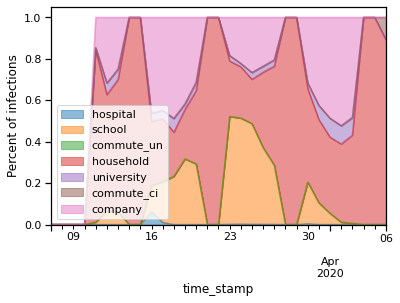

In [39]:
locations_per_day.plot.area( alpha=0.5)
plt.legend(loc='lower left')
plt.ylabel('Percent of infections')

Text(0.5, 0, 'location')

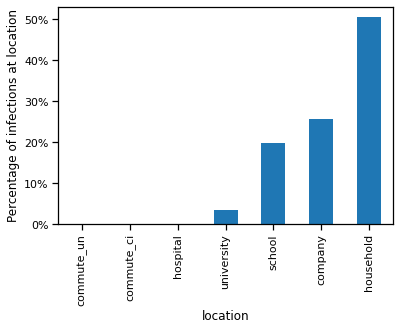

In [40]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

## rate of infection

In [41]:
r_df = read.get_r()

Text(0, 0.5, 'R')

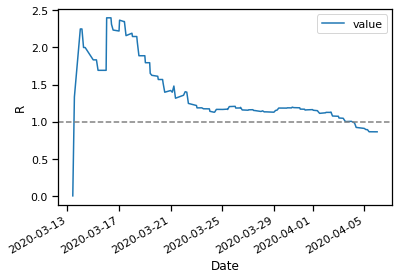

In [42]:
r_df.plot()
#plt.axvspan(policies.social_distancing_start, 
#            policies.social_distancing_end,
#            facecolor='y', alpha=0.2)
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.ylabel('R')

## World infection curves, and by super area

In [43]:
world_df = read.world_summary()

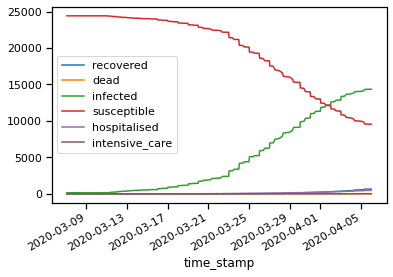

In [44]:
world_df.plot()
#plt.axvspan(policies.social_distancing_start, 
#            policies.social_distancing_end,
#            facecolor='y', alpha=0.2)
plt.legend()

In [45]:
area_df = read.super_area_summary()

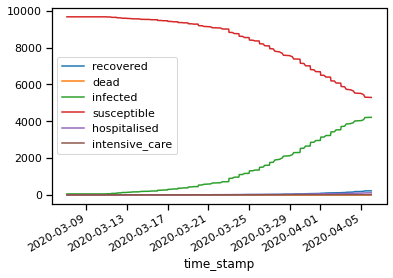

In [46]:
area_df[area_df.super_area == "E02001720"].plot()
plt.legend()

## World infection curves per age group

In [47]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

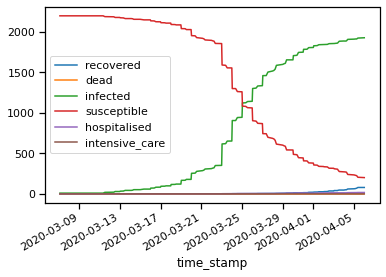

In [48]:
ages_df[ages_df['age_range'] == '0_9'].plot()

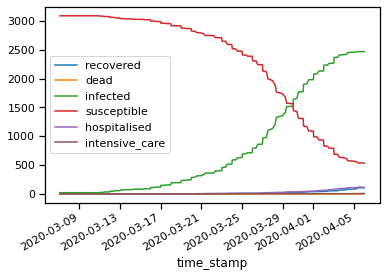

In [49]:
ages_df[ages_df['age_range'] == '40_49'].plot()

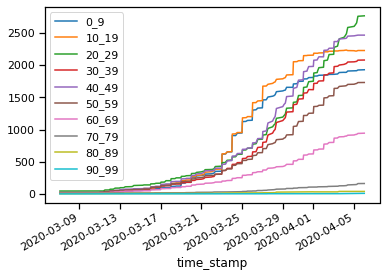

In [50]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
#plt.axvspan(policies.social_distancing_start, 
#            policies.social_distancing_end,
#            facecolor='y', alpha=0.2)
plt.legend()

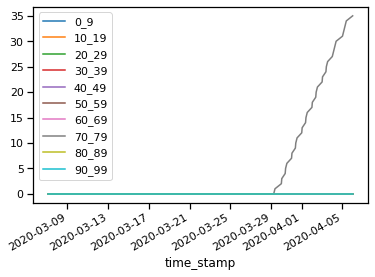

In [51]:
for name, group in ages_df.groupby('age_range'):
    group['dead'].cumsum().plot(label=name)
plt.legend()

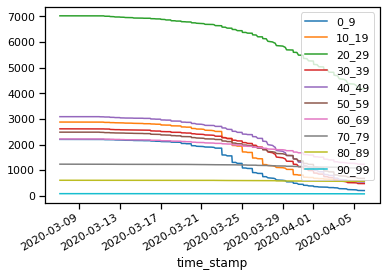

In [52]:
for name, group in ages_df.groupby('age_range'):
    group['susceptible'].plot(label=name)
plt.legend()

## Draw some of the symptoms trajectories

In [53]:
random_trajectories = read.draw_symptom_trajectories(window_length=200,
                                        n_people=5)

In [54]:
from june.infection import SymptomTag

In [55]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


Text(0.5, 0, 'Date')

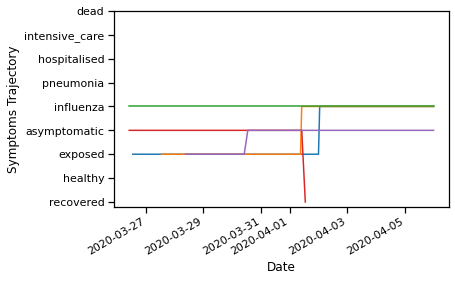

In [56]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

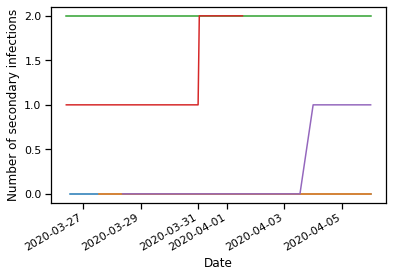

In [57]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')